# EE538 2021 Presentation
## Diman

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

def plot_xlogy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.semilogx(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def plot_xy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.plot(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
k = 1.38e-23                 # Boltzmann constant, J/K
T = 300                      # room temperature (27C) in Kelvin
q = 1.6e-19                  # charge of an electron
kT = k*T

Diode has only shot noise:
\begin{equation}
e_{nd} = \sqrt{2 q I_d}
\end{equation}

In [3]:
diode_noise = np.sqrt(2 * q * 2e-6)
display(f'diode noise: {diode_noise}')

'diode noise: 7.999999999999999e-13'

Photodiode noise: $.8 pA/\sqrt{Hz}$

Photodiode noise across bandwidth: $.8 \sqrt{1e^6} = 800 pA$

Noise budget: 
\begin{equation}
.5 dB = 10 \times 10^{\frac{0.5}{10}} = 1.12202\\
800 \times 1.12202 - 800 = 97.6 pA
\end{equation}

## References
- Graeme Book 1995 - discrete bootstrap frontend
- Hobbs Paper 2001 - discrete cascode + bootstrap "no such IC exists"
- Hobbs Book 2009 - same as paper "expensive IC exists"
- Hamamtsu Opto-semiconductor Handbook 2014 - ~dozen IC only circuits, 1 JFET circuit (low cost)

## IC Choice
Hobbs outlines IC requirements:
1. $i_{namp} < 0.5 i_{nth}$. $R_f$ current noise dominates $i_{namp}$
2. $e_{namp} < 0.5 e_{nth}$. $R_f$ voltage noise dominates $e_{namp}$
3. $e_{namp} < 0.5 i_{nth} / (2 \pi f_{3dB} (C_d + C_in)$. Noise peak should be outside of signal band
4. $f_T > 2 f^2_{3dB} / f_{RC}$. Amplifier has to raise the signal bandwidth enough.

## Discussion:
1. $i_{namp} < 0.5 i_{nth}$. OpAmps with current noise in femto-amp range are readily available.
2. $e_{namp} < 0.5 e_{nth}$. $100k$ resistor has 40nV voltage noise. $e_{namp}<20nV$ is easy.
3. $e_{namp} < 0.5 i_{nth} / (2 \pi f_{3dB} (C_d + C_{in}))$. !!!
4. $f_T > 2 f^2_{3dB} / f_{RC}$. $0.5Ghz$ OpAmps are readily available.

| Parameter | LF356 | LTC6269 | Unit |
| :----------------:  | :----------------: | :----------------: | :---: |
| $i_n$ | f=1kHz, V_C=15V, 10 | f=100kHz, V_C=2.75V, 5.5 | fA |
| $e_n$ | f=1kHz, V_C=15V, 12 | f=1MHz, V_C=2.75V, 4.3 | nV/rtHz |
| $f_T$ | 5 | 500 | MHz |
| $C_{in}$| 3 | .45 | pF|
| Current Supply | 75 | 51 | mW |
| price / 1000 | 1 Channel, .9 | 2 Channel, 7 | $ |


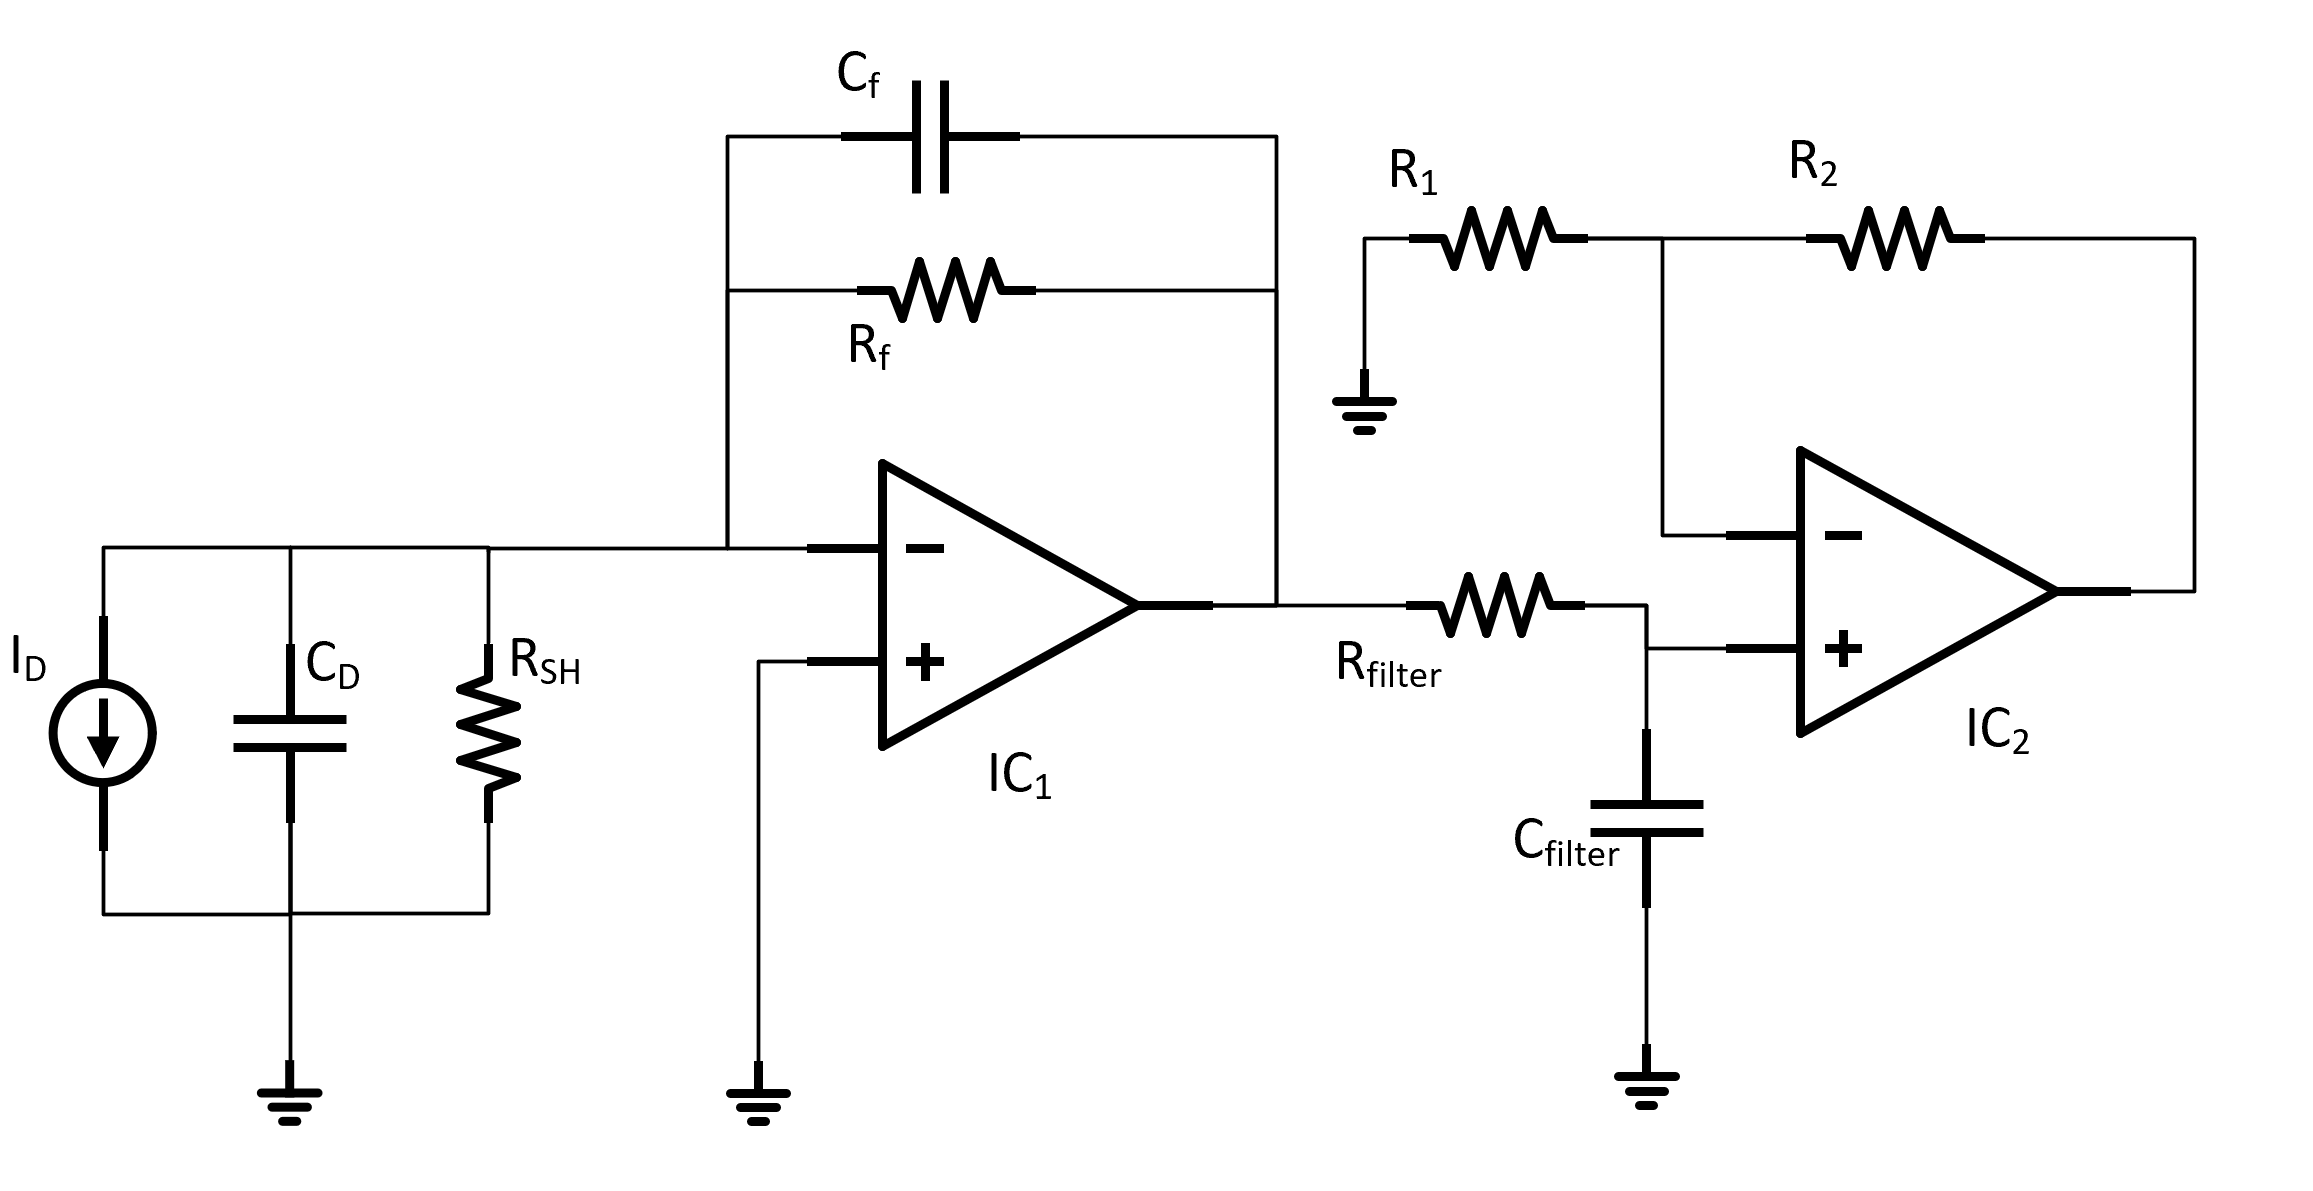

In [4]:
C_D = 150e-12 # pF

C_f = 0.68e-12 # pF \approx 0
R_f = 240e3 # kOhm

e_namp = 4.3e-9 # nV
i_namp = 5.3e-15 # fA \approx 0
f_T = 500e6 # MHz

C_filter = 1.5e-9 # pF
R_filter = 100 # Ohm

R_1 = 510 # Ohm
R_2 = 1.8e3 # kOhm

In [6]:
f = np.linspace(1, 10**9,10**6)
s = np.multiply(2*np.pi, f)

zeta = 1 / np.sqrt(2)
omega_u = 2 * np.pi * f_T
omega_0_2 = omega_u / (R_f*C_D)
omega_0 = np.sqrt(omega_0_2)

tf_tia_mag = R_f * omega_0_2 / np.sqrt( (s*np.sqrt(2)*omega_0)**2 + (omega_0_2-s**2)**2)
tf_filter_mag = 1 / np.sqrt((s*R_filter*C_filter)**2 + 1)
tf_noninv_mag = 1 + R_2 / R_1 # assuming ideal opamp
tf_amp_mag = tf_tia_mag * tf_filter_mag * tf_noninv_mag

Frequency Response

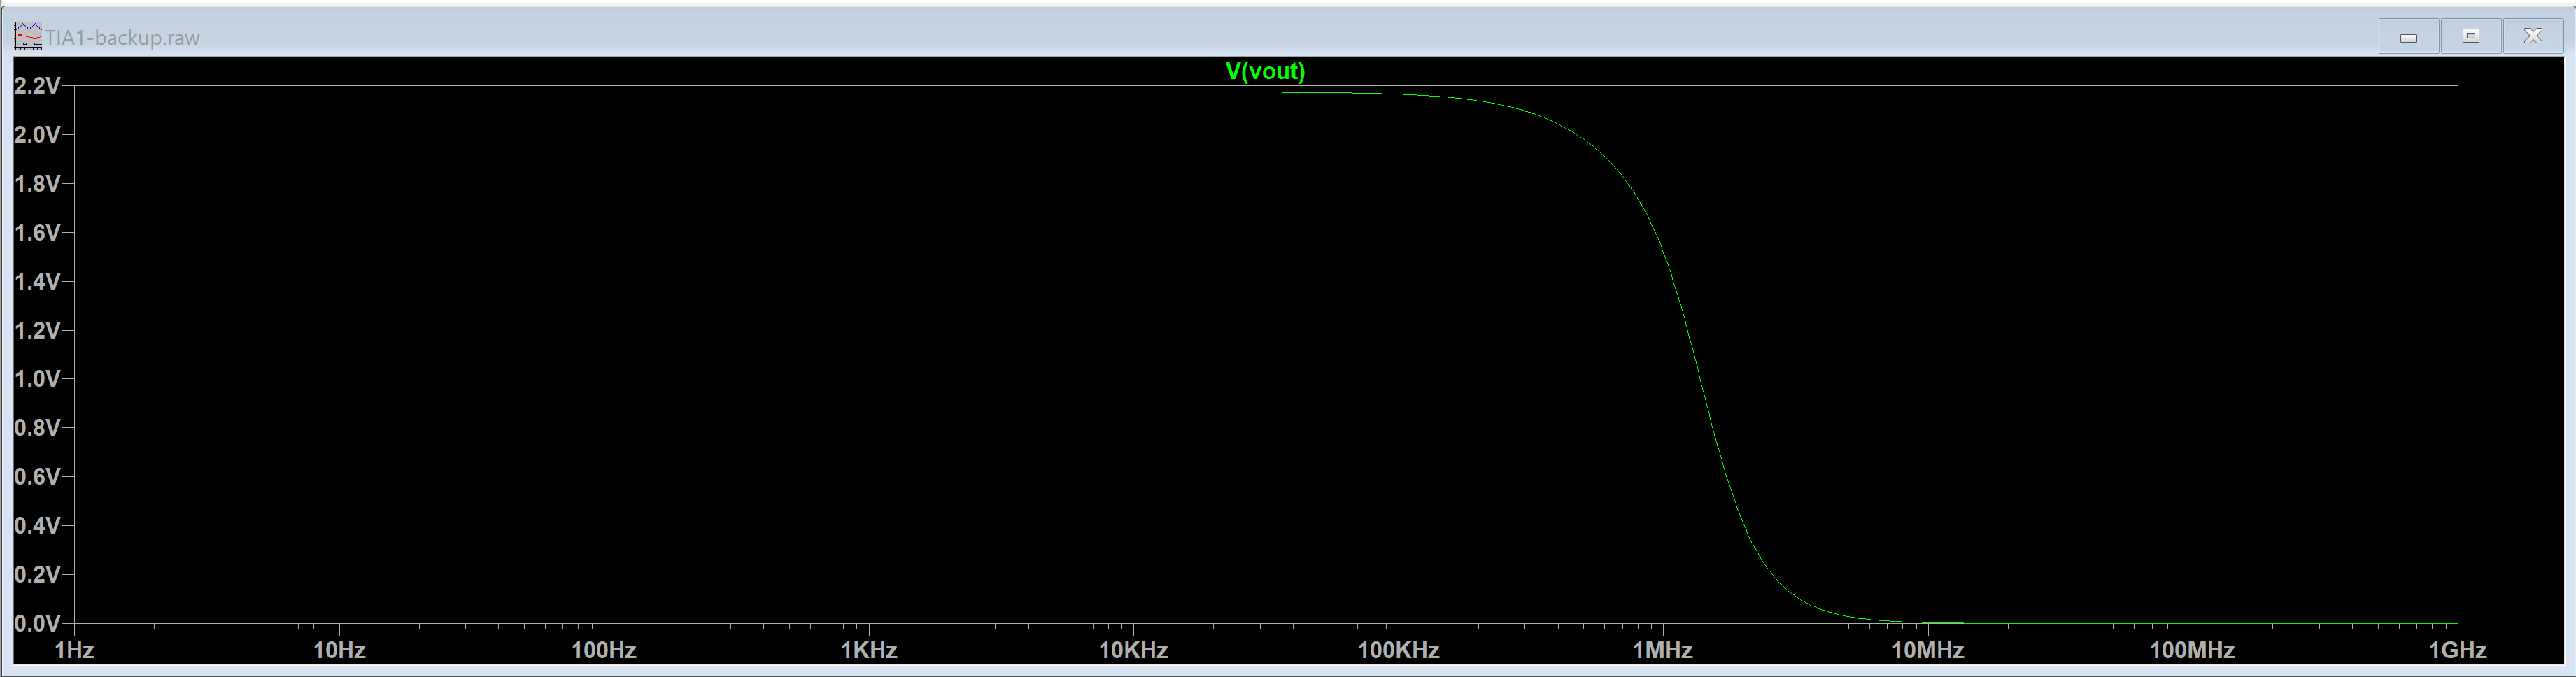

In [7]:
i_tia_e_na = e_namp * s * C_D
e_tia_na = i_tia_e_na * tf_tia_mag

e_nRf2 = 4 * kT * R_f
e_nRf = np.sqrt(e_nRf2)
e_tia_nRf = (e_nRf/R_f) * tf_tia_mag

e_tia = np.sqrt(e_tia_na**2 + e_tia_nRf**2) 

(1485002.4835164833, 1.0235105449358729e-06)

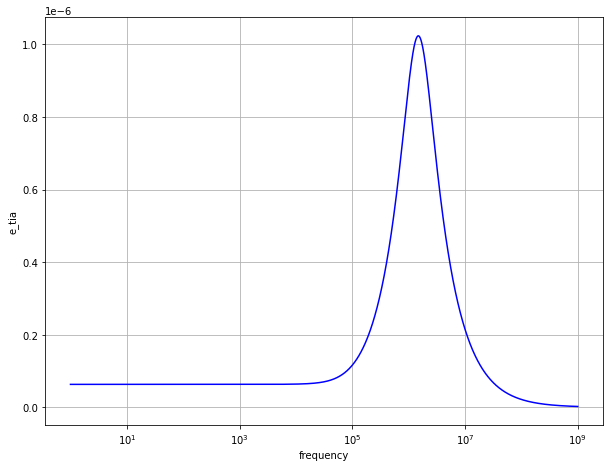

In [8]:
plot_xlogy(f, e_tia, "frequency", "e_tia")
x = np.argmax(e_tia)
f[x],e_tia[x]


Noise Peak

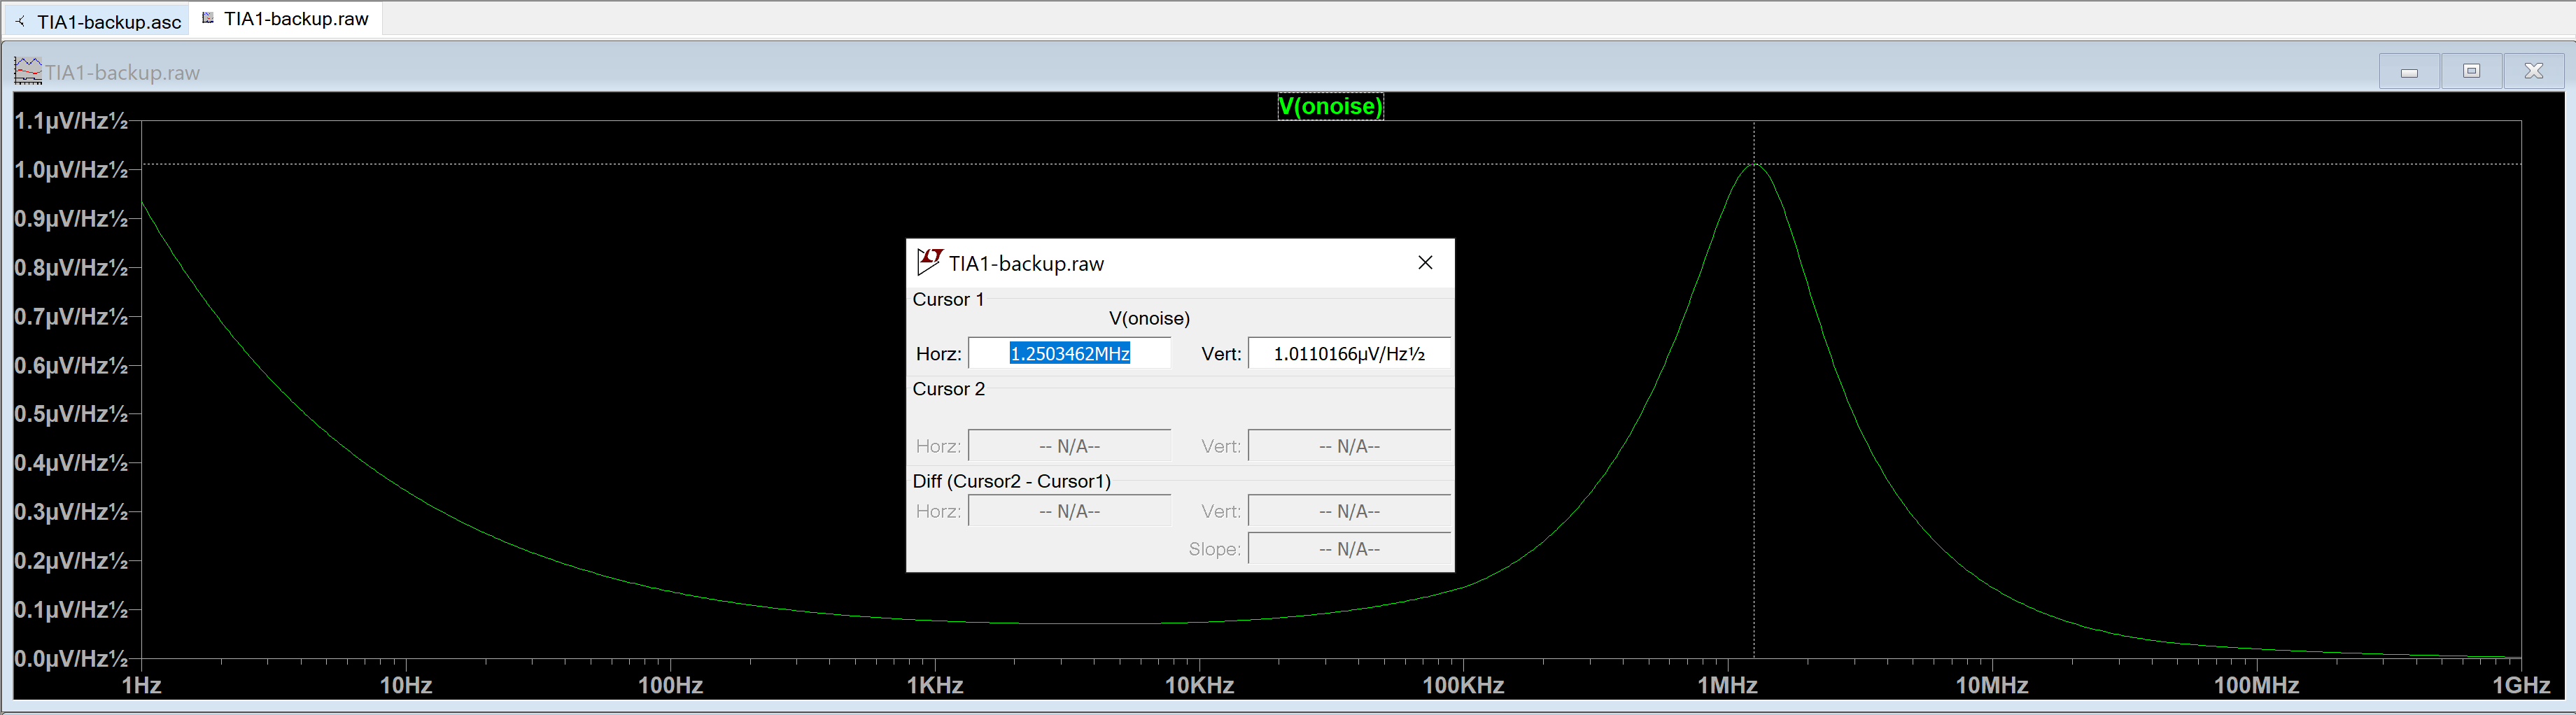

In [9]:
e_nRfilter = np.sqrt(4 * kT * R_filter) * tf_noninv_mag
e_nR2 = np.sqrt(4 * kT * R_2)
e_nR1 = np.sqrt(4 * kT * R_1) * tf_noninv_mag

R_1_p_R_2 = R_1 * R_2 / (R_1 + R_2)
e_i_namp = i_namp * R_1_p_R_2 * tf_noninv_mag
e_e_namp = e_namp * tf_noninv_mag

e_tot = np.sqrt((e_tia * tf_filter_mag * tf_noninv_mag) ** 2 + e_nRfilter**2 + e_nR2**2 + e_nR1**2 + e_i_namp**2 + e_e_namp**2)


(1110002.1088911088, 2.956571349305111e-06)

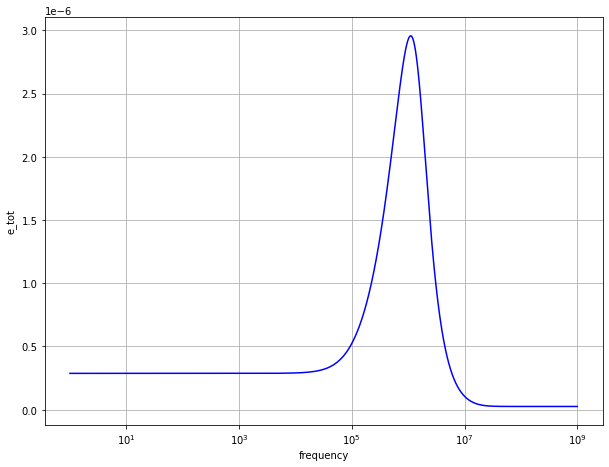

In [10]:
plot_xlogy(f, e_tot, "frequency", "e_tot")
x = np.argmax(e_tot)
f[x],e_tot[x]

Total Noise

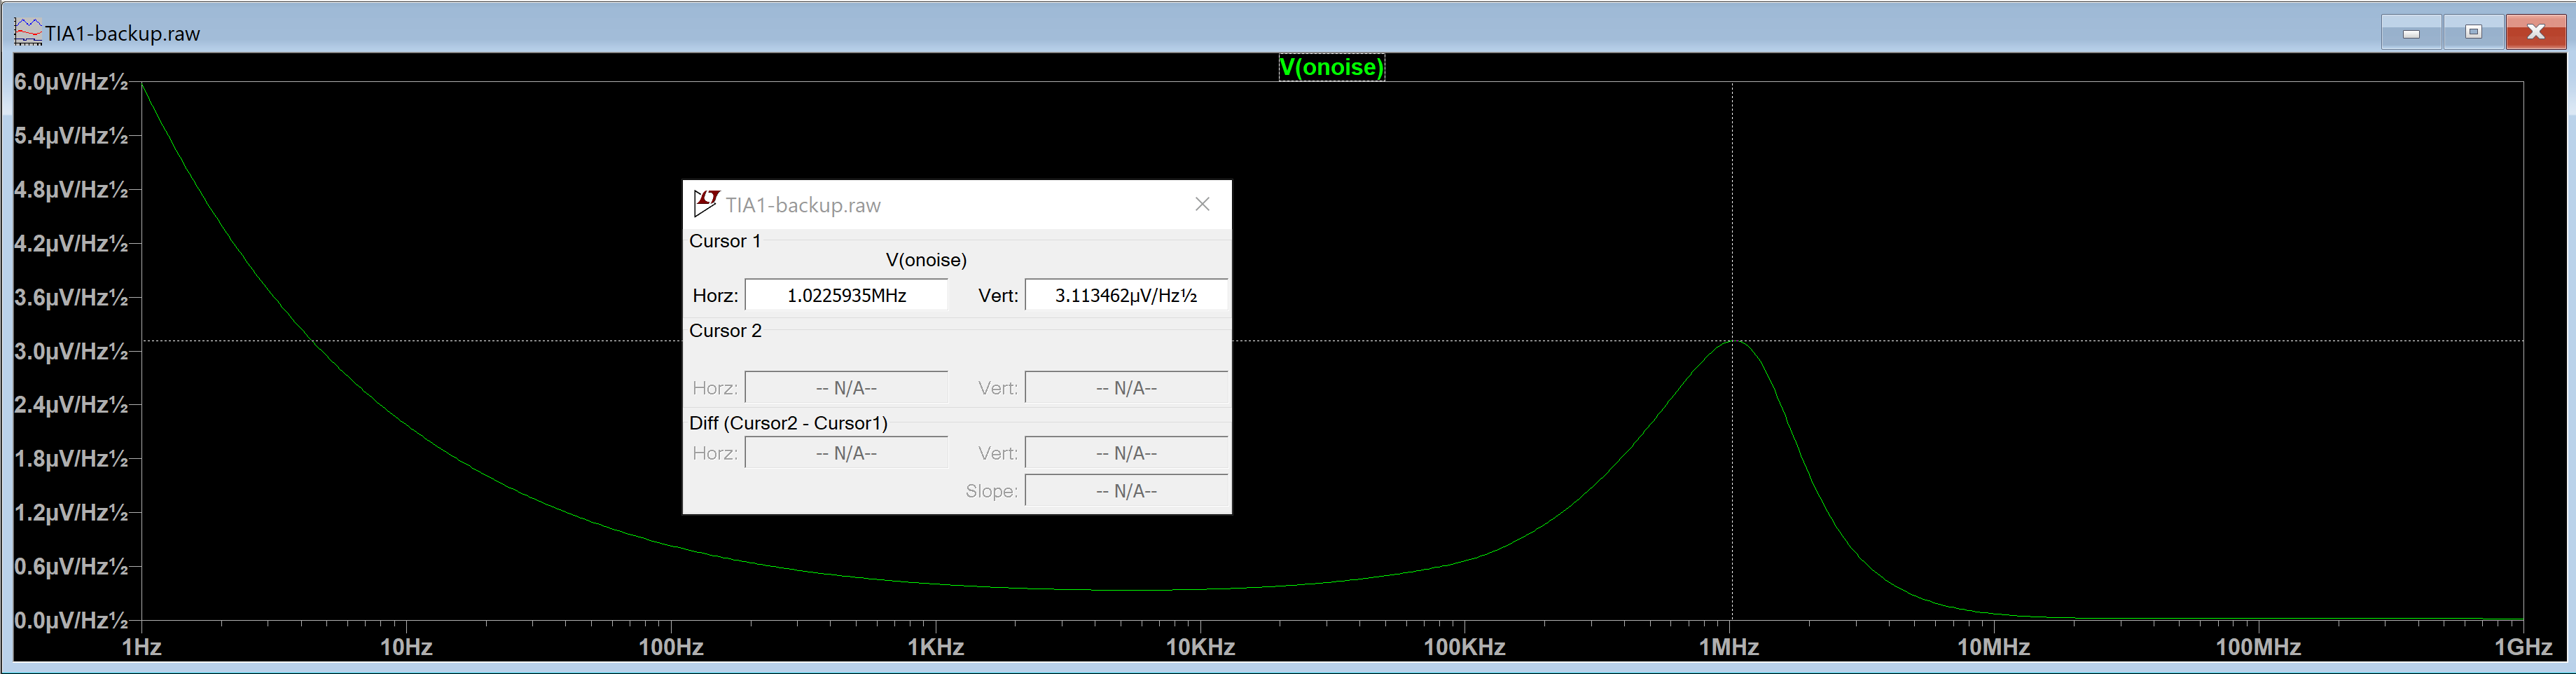

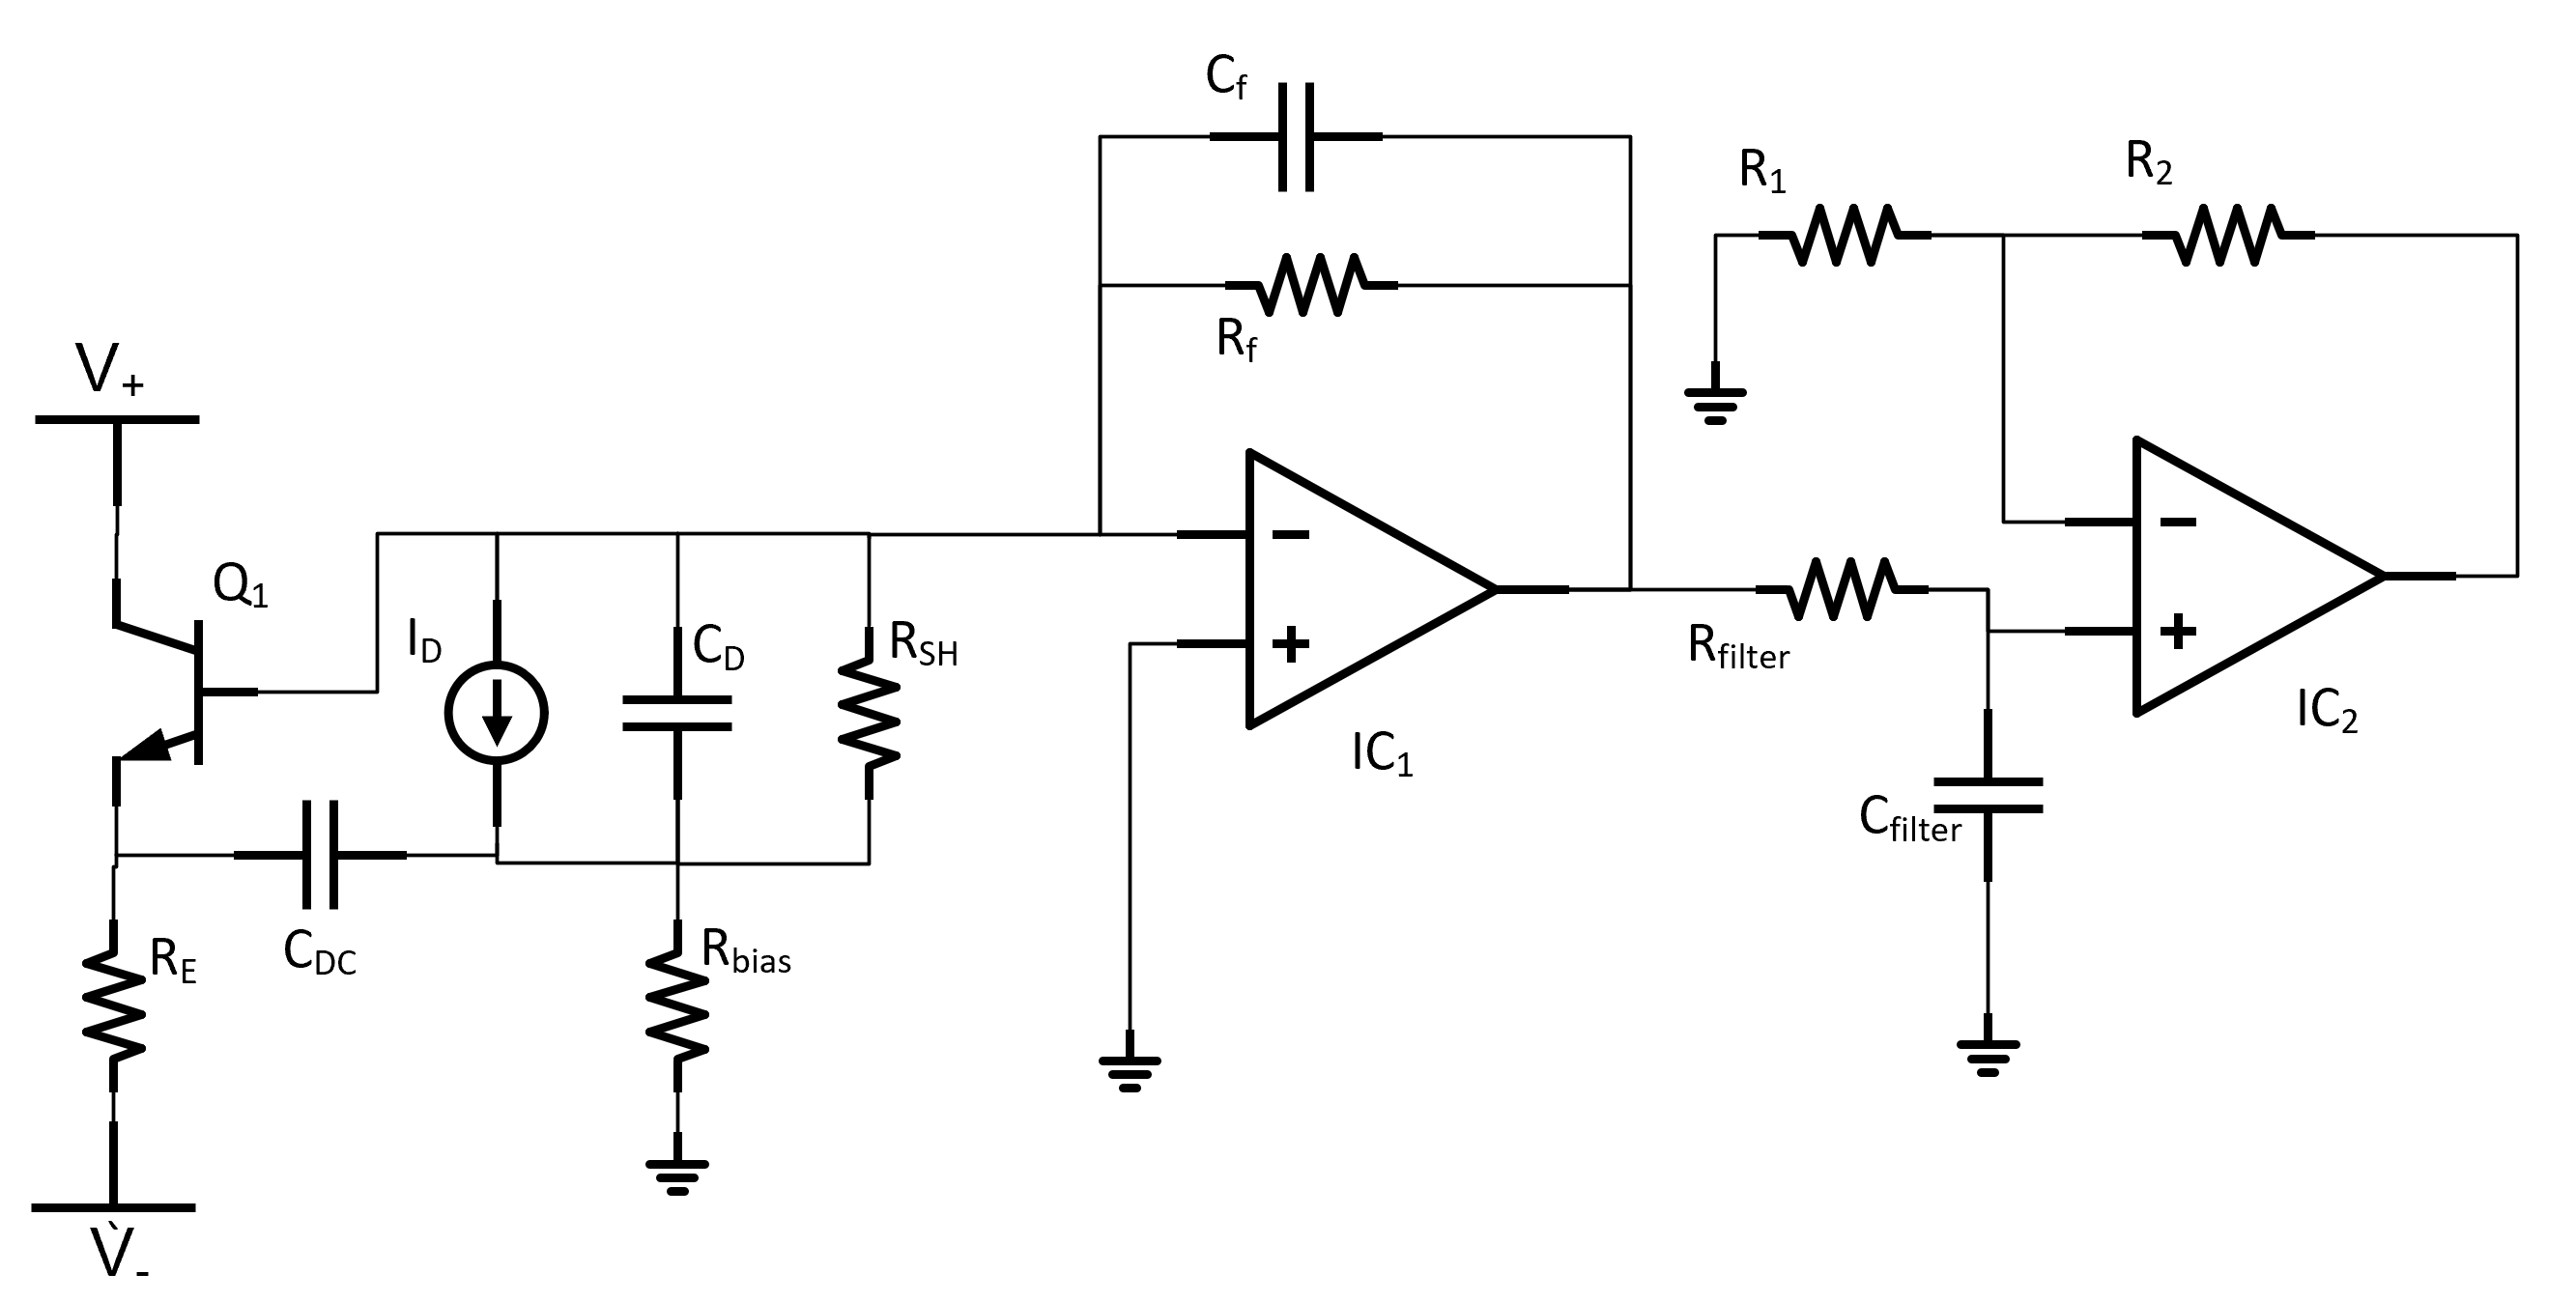

Bootstrapped TIA Simulation

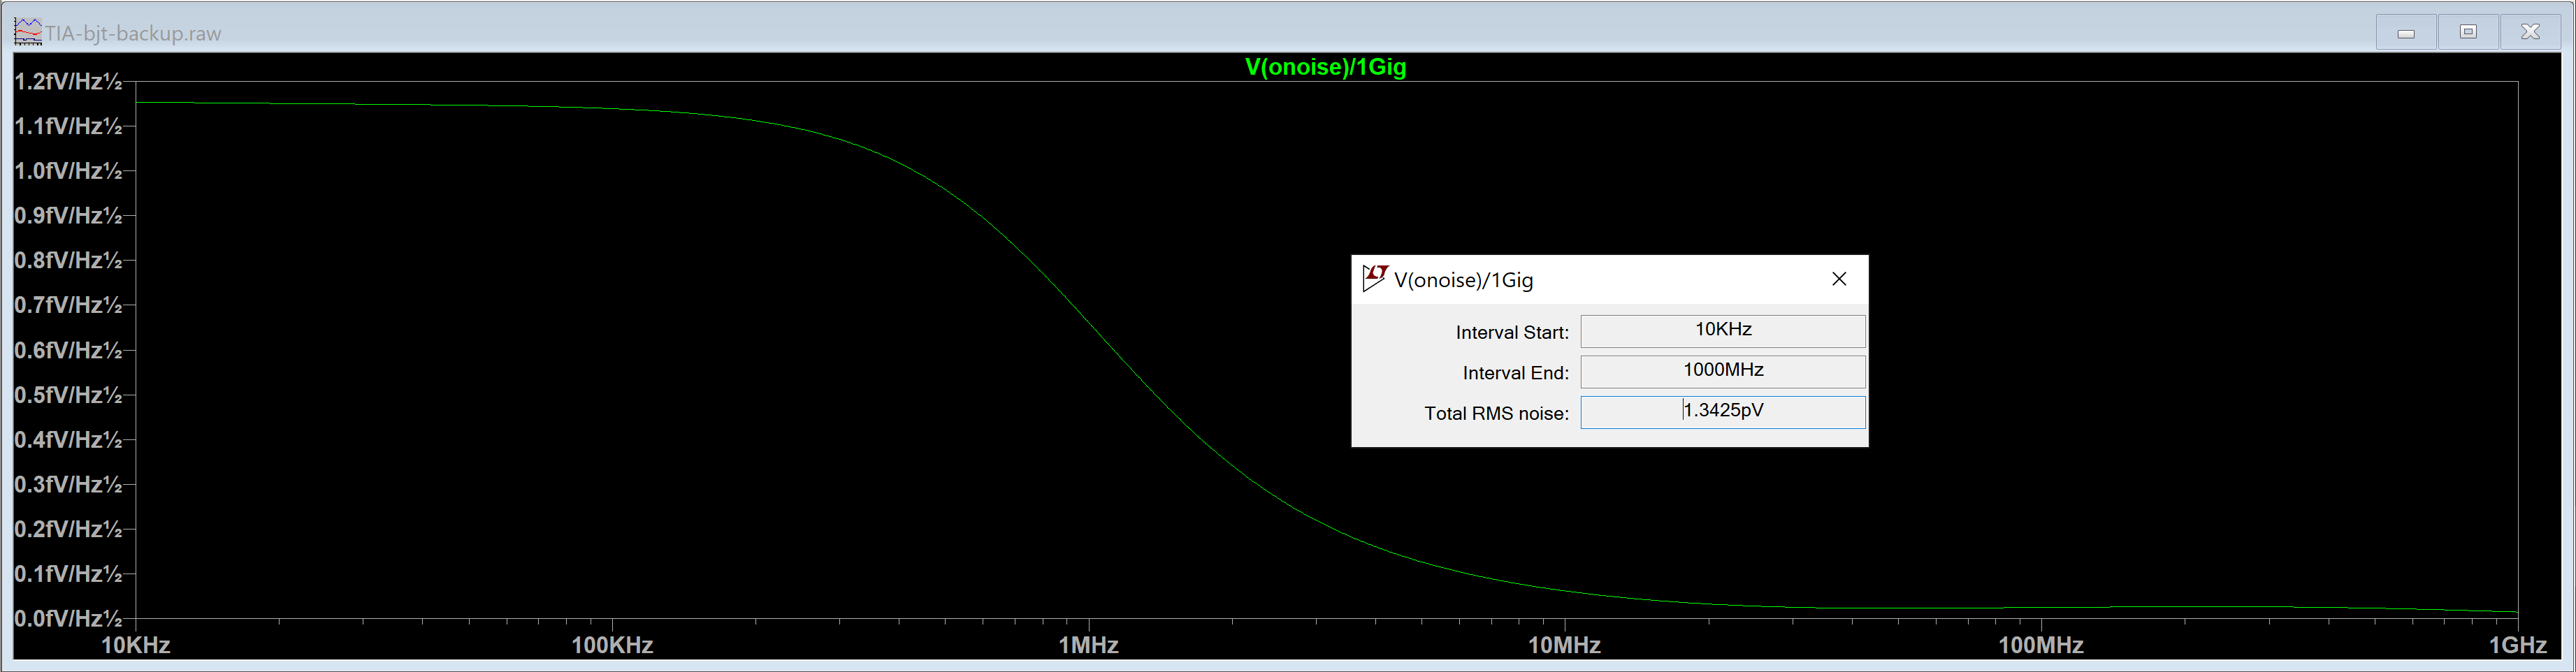

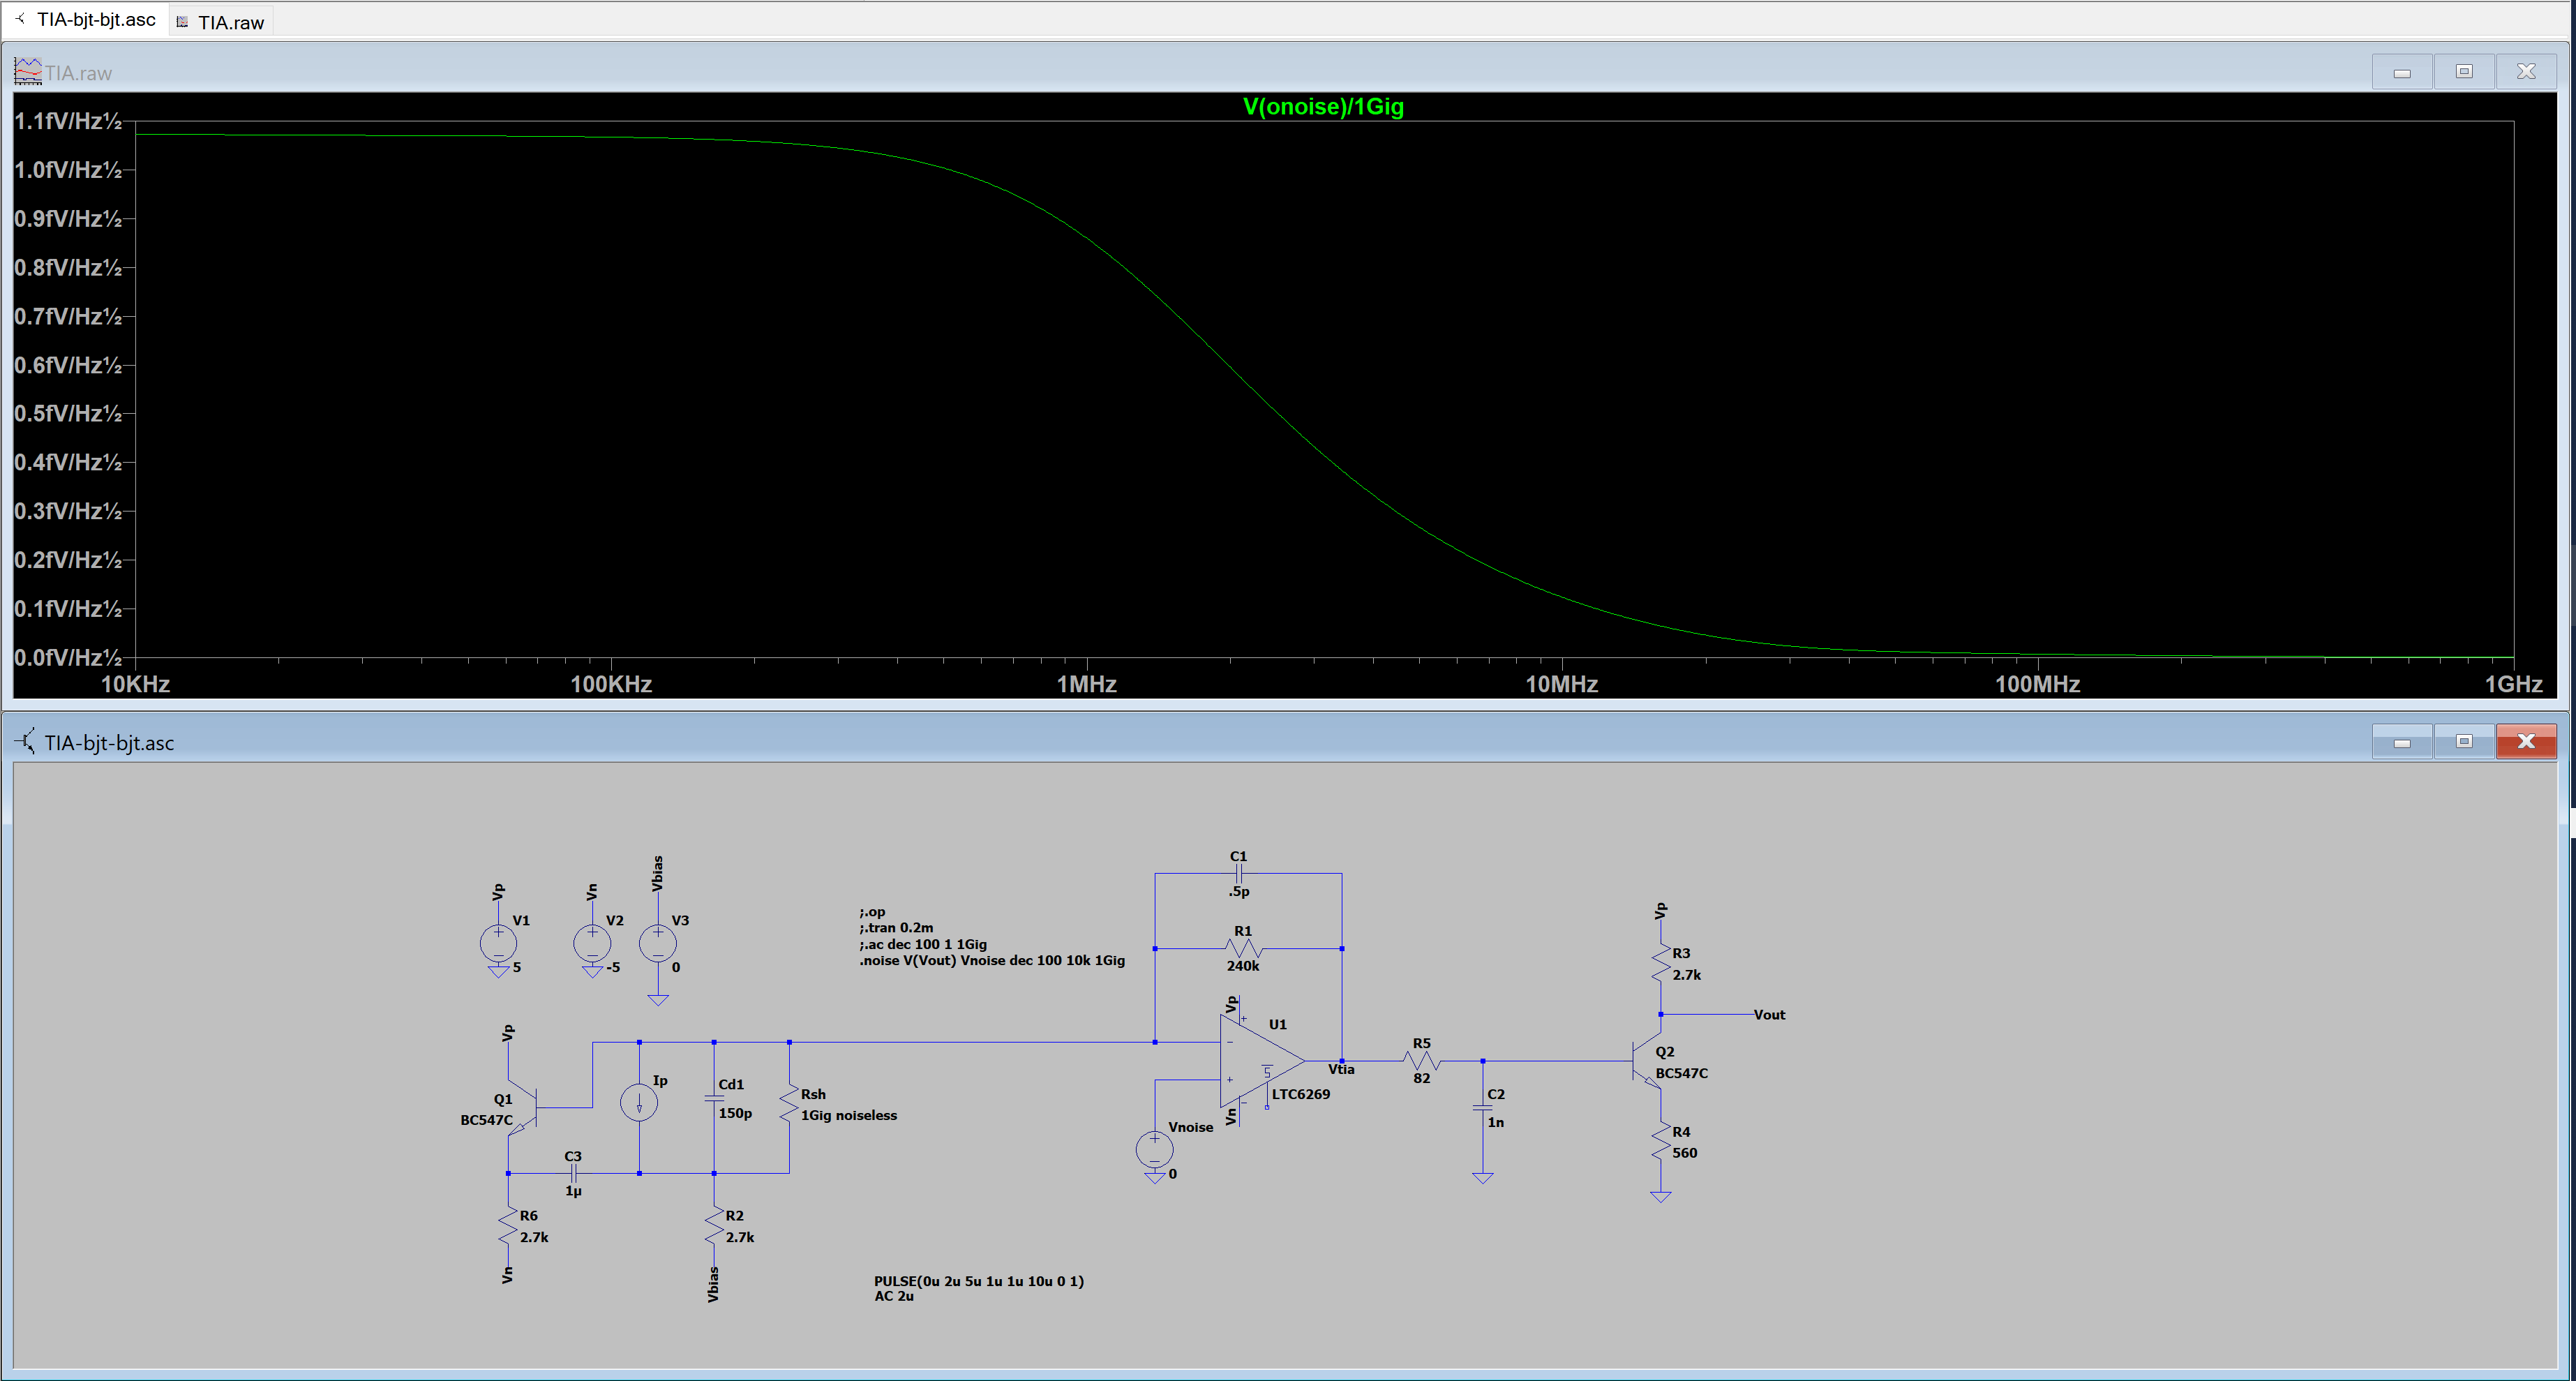

## Justification
Expensive OpAmp however:
- More components $\rightarrow$ 
    - parasitic caps
    - logistic cost
    - expensive board construction
- 150pF / 1MHz / 1$G\Omega$ spec implies low production volume
    - optic communications use small area diodes 1pF
    - medical applications use smaller transconductance
    